# Association Rule Mining


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

import plotly
import plotly.graph_objs as go

from tqdm.notebook import tqdm

%matplotlib inline

Scikit-Learn does not support association rule learning. Fortunately though, [Sebastian Raschka](https://sebastianraschka.com) (a personal hero of mine) implemented this (and many other cool things) in his library *mlextend*, which aims to be as Scikit-Learn compatible as possible.

You can find examples for generating frequent itemsets with apriori [here](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) and for association rule mining [here](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/).

## Manually
But first, we do a little manual calculation. You are given the following dataset of transactions.

In [37]:
transactions = [['oats', 'lego', 'teddybear', 'rc car'],
                ['oats', 'red coat', 'gloves', 'teddybear', 'doll', 'warm boot'],
                ['lego', 'red jelly bag cap', 'rc car', 'doll'],
                ['lego', 'oats', 'large red bag', 'gift wrap paper', 'warm boot']]

transactions = pd.DataFrame(data={"Items":transactions}, index=range(1,5))
transactions.index.name = 'Id'

with pd.option_context('display.max_colwidth', 80):
    print(transactions)

                                                      Items
Id                                                         
1                           [oats, lego, teddybear, rc car]
2      [oats, red coat, gloves, teddybear, doll, warm boot]
3                   [lego, red jelly bag cap, rc car, doll]
4   [lego, oats, large red bag, gift wrap paper, warm boot]


> Calculate the support for lego, oats and doll (manunally or by code, your choice).

In [61]:
def calcSupport(string,df):        
    counts = 0
    print(len(transactions))
    for i in range(len(transactions)):
        contains = False
        contains = item in transactions.Items[i+1]
        if contains:
            counts += 1
    print(item + ": " + str(counts/len(transactions)))
    
values = ['lego','oats','doll']
for item in values:
    calcSupport(item,transactions)

4
lego: 0.75
4
oats: 0.75
4
doll: 0.5


In [40]:
# support_lego = 3/4
# support_oats = 3/4
# support_doll = 2/4

# or with code, for example:
support = {}
for item in ['lego', 'oats', 'doll']:
    support[item] = transactions.Items.map(lambda x: item in x).sum() / transactions.shape[0] # support of 'lego'
support

{'lego': 0.75, 'oats': 0.75, 'doll': 0.5}

> Calculate the confidence of `['lego', 'oats'] -> ['teddybear']`

In [65]:
0.25/(2/4)

0.5

In [62]:
# confidence_lego_oats-teddybear = 0.25 / 0.5
0.25 / ( transactions.Items.map(lambda x: 'lego' in x and 'oats' in x).sum() / transactions.shape[0]  )

0.5

Now apply the Apriori algorithm and find the frequent item sets with a minimum support of 0.5 and minimum confidence of 0.75. Here is the dataset again:

In [66]:
with pd.option_context('display.max_colwidth', 80):
    print(transactions)

                                                      Items
Id                                                         
1                           [oats, lego, teddybear, rc car]
2      [oats, red coat, gloves, teddybear, doll, warm boot]
3                   [lego, red jelly bag cap, rc car, doll]
4   [lego, oats, large red bag, gift wrap paper, warm boot]


> **Step 1**: Generate frequent item sets satisfying the support threshold (hint: there are 6 itemsets of length 1 and 4 itemsets of length 2)

In [75]:
te = TransactionEncoder()
te_ary = te.fit_transform(transactions.Items.values.tolist())
df = pd.DataFrame(te_ary, columns=te.columns_)
apriori(df,min_support=0.5,use_colnames=True,)

,support,itemsets
0,0.50,(doll)
1,0.75,(lego)
2,0.75,(oats)
3,0.50,(rc car)
4,0.50,(teddybear)
5,0.50,(warm boot)
6,0.50,"(oats, lego)"
7,0.50,"(rc car, lego)"
8,0.50,"(teddybear, oats)"
9,0.50,"(oats, warm boot)"


In [69]:
# Execute the following code to show the solution. We will see how to use this library in a minute.
te = TransactionEncoder()
te_ary = te.fit_transform(transactions.Items.values.tolist())
df = pd.DataFrame(te_ary, columns=te.columns_)
print(df)
freq_itemsets = apriori(df, use_colnames=True, min_support=0.5)
freq_itemsets

    doll  gift wrap paper  gloves  large red bag   lego   oats  rc car  \
0  False            False   False          False   True   True    True   
1   True            False    True          False  False   True   False   
2   True            False   False          False   True  False    True   
3  False             True   False           True   True   True   False   

   red coat  red jelly bag cap  teddybear  warm boot  
0     False              False       True      False  
1      True              False       True       True  
2     False               True      False      False  
3     False              False      False       True  


,support,itemsets
0,0.50,(doll)
1,0.75,(lego)
2,0.75,(oats)
3,0.50,(rc car)
4,0.50,(teddybear)
5,0.50,(warm boot)
6,0.50,"(oats, lego)"
7,0.50,"(rc car, lego)"
8,0.50,"(teddybear, oats)"
9,0.50,"(oats, warm boot)"


> **Step 2**: Extract rules from frequent item sets satisfying the confidence threshold (hint: there are three itemsets)

There are 8 candidates: From all 4 itemsets with two items, generate the two possibilities.

From these 8 candidates, 4 have a confidence of 0.5/0.75 which is below the threshold and 4 have a confidence of 0.5/0.5 which is above.

In [76]:
# Execute the following code to show the solution
association_rules(freq_itemsets, metric='confidence', min_threshold=0.75)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(rc car),(lego),0.5,0.75,0.5,1.0,1.333333,0.125,inf
1,(teddybear),(oats),0.5,0.75,0.5,1.0,1.333333,0.125,inf
2,(warm boot),(oats),0.5,0.75,0.5,1.0,1.333333,0.125,inf


Ok, enough manual calculation with a toy example for today. Let's work with a bigger dataset.

## Automated
You are given some transactional data about purchases in a supermarket.

In [77]:
transactions = pd.read_csv('acostasg.csv')
transactions.columns = ['Date', 'Transaction', 'Item']
transactions.head()

,Date,Transaction,Item
0,2000-01-01,1,pork
1,2000-01-01,1,sandwich bags
2,2000-01-01,1,lunch meat
3,2000-01-01,1,all- purpose
4,2000-01-01,1,flour


In [78]:
transactions.shape

(22342, 3)

There is a kind of placeholder item *'all- purpose'* (notice the space after the dash) in the data which appears multiple times in some transactions. 
> Remove rows with this item. 

In [83]:
transactions.drop(transactions.index[transactions['Item'] == 'all- purpose'], inplace=True)

In [81]:
transactions = transactions[transactions.Item != 'all- purpose']

In [84]:
transactions.shape

(21791, 3)

### Group by transaction ID
We group the data by transaction id and aggregate purchases into a list (the Date is constant for s single transaction).

In [85]:
transactions = transactions.groupby('Transaction').agg({'Date':lambda x: x.iloc[0] ,'Item':list})
transactions.head()

,Date,Item
Transaction,,
1,2000-01-01,"[pork, sandwich bags, lunch meat, flour, soda,..."
2,2000-01-01,"[toilet paper, shampoo, hand soap, waffles, ve..."
3,2000-01-02,"[soda, pork, soap, ice cream, toilet paper, di..."
4,2000-01-02,"[cereals, juice, lunch meat, soda, toilet paper]"
5,2000-01-02,"[sandwich loaves, pasta, tortillas, mixes, han..."


### Calculate size for each transaction
We also calculate the size for each transaction.
> `map` the function `len` on each row of the *Item* column.

In [91]:
transactions['Size'] = transactions['Item'].map(len)
transactions.head()

,Date,Item,Size
Transaction,,,
1,2000-01-01,"[pork, sandwich bags, lunch meat, flour, soda,...",16
2,2000-01-01,"[toilet paper, shampoo, hand soap, waffles, ve...",23
3,2000-01-02,"[soda, pork, soap, ice cream, toilet paper, di...",31
4,2000-01-02,"[cereals, juice, lunch meat, soda, toilet paper]",5
5,2000-01-02,"[sandwich loaves, pasta, tortillas, mixes, han...",26


In [89]:
transactions['Size'] = transactions['Item'].map(len)
transactions.head()

,Date,Item,Size
Transaction,,,
1,2000-01-01,"[pork, sandwich bags, lunch meat, flour, soda,...",16
2,2000-01-01,"[toilet paper, shampoo, hand soap, waffles, ve...",23
3,2000-01-02,"[soda, pork, soap, ice cream, toilet paper, di...",31
4,2000-01-02,"[cereals, juice, lunch meat, soda, toilet paper]",5
5,2000-01-02,"[sandwich loaves, pasta, tortillas, mixes, han...",26


### Statistics

In [92]:
transactions.describe()

,Size
count,1139.000000
mean,19.131694
std,8.264745
min,4.000000
25%,12.000000
50%,19.000000
75%,26.000000
max,34.000000


array([[<AxesSubplot:title={'center':'Size'}>]], dtype=object)

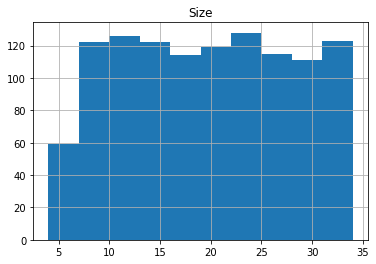

In [93]:
transactions.hist()

The mlxtend library offers a function to turn a list of transactions into the required binary transaction format: 

In [94]:
te = TransactionEncoder()
te_binary = te.fit_transform(transactions.Item)

df = pd.DataFrame(te_binary, columns=te.columns_)
df.head()

,aluminum foil,bagels,beef,butter,cereals,cheeses,coffee/tea,dinner rolls,dishwashing liquid/detergent,eggs,...,shampoo,soap,soda,spaghetti sauce,sugar,toilet paper,tortillas,vegetables,waffles,yogurt
0,True,False,True,True,False,False,False,True,False,False,...,True,True,True,False,False,False,False,True,False,False
1,True,False,False,False,True,True,False,False,True,False,...,True,False,False,False,False,True,True,True,True,True
2,False,True,False,False,True,True,False,True,False,True,...,True,True,True,True,False,True,False,True,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,True,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,True,False,True,...,False,False,True,True,False,True,True,True,True,True


### Association Rule Mining
> Generate frequent itemsets with a minimum support of 0.05. Look at the examples linked above or given in the solutions of the toy example for hints.

In [96]:
freq_itemsets = apriori(df, min_support=0.05, use_colnames=True)
freq_itemsets

,support,itemsets
0,0.384548,(aluminum foil)
1,0.385426,(bagels)
2,0.374890,(beef)
3,0.367867,(butter)
4,0.395961,(cereals)
...,...,...
14563,0.058824,"(yogurt, sugar, vegetables, waffles)"
14564,0.055312,"(toilet paper, tortillas, vegetables, waffles)"
14565,0.053556,"(toilet paper, tortillas, vegetables, yogurt)"
14566,0.064969,"(toilet paper, yogurt, vegetables, waffles)"


In [ ]:
freq_itemsets = apriori(df, min_support=0.05, use_colnames=True)

> Now extract all association rules with a confidence threshold of 0.5.

In [98]:
rules = association_rules(freq_itemsets, metric='confidence', min_threshold=0.5)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(aluminum foil),(vegetables),0.384548,0.739245,0.310799,0.808219,1.093304,0.026524,1.359651
1,(bagels),(vegetables),0.385426,0.739245,0.300263,0.779043,1.053836,0.015339,1.180118
2,(beef),(vegetables),0.374890,0.739245,0.291484,0.777518,1.051773,0.014348,1.172025
3,(butter),(vegetables),0.367867,0.739245,0.283582,0.770883,1.042798,0.011639,1.138087
4,(cereals),(vegetables),0.395961,0.739245,0.310799,0.784922,1.061789,0.018087,1.212377
...,...,...,...,...,...,...,...,...,...
10515,"(sugar, waffles, yogurt)",(vegetables),0.069359,0.739245,0.058824,0.848101,1.147253,0.007550,1.716637
10516,"(toilet paper, tortillas, waffles)",(vegetables),0.068481,0.739245,0.055312,0.807692,1.092591,0.004687,1.355926
10517,"(toilet paper, tortillas, yogurt)",(vegetables),0.064969,0.739245,0.053556,0.824324,1.115090,0.005528,1.484298
10518,"(toilet paper, waffles, yogurt)",(vegetables),0.082529,0.739245,0.064969,0.787234,1.064916,0.003960,1.225549


In [99]:
rules = association_rules(freq_itemsets, metric='confidence', min_threshold=0.5)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(aluminum foil),(vegetables),0.384548,0.739245,0.310799,0.808219,1.093304,0.026524,1.359651
1,(bagels),(vegetables),0.385426,0.739245,0.300263,0.779043,1.053836,0.015339,1.180118
2,(beef),(vegetables),0.374890,0.739245,0.291484,0.777518,1.051773,0.014348,1.172025
3,(butter),(vegetables),0.367867,0.739245,0.283582,0.770883,1.042798,0.011639,1.138087
4,(cereals),(vegetables),0.395961,0.739245,0.310799,0.784922,1.061789,0.018087,1.212377


> Sort this so that the rules with the highest lift are at the top and print the top ten rules.

In [100]:
rules.sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7152,"(pasta, eggs, ice cream)",(paper towels),0.085162,0.362599,0.055312,0.649485,1.791193,0.024432,1.818468
7154,"(eggs, paper towels, ice cream)",(pasta),0.086040,0.371378,0.055312,0.642857,1.731003,0.023358,1.760140
2695,"(sandwich bags, bagels, cereals)",(cheeses),0.075505,0.390694,0.050922,0.674419,1.726209,0.021423,1.871441
2358,"(toilet paper, aluminum foil, yogurt)",(juice),0.078139,0.376646,0.050044,0.640449,1.700401,0.020613,1.733703
2464,"(aluminum foil, yogurt, poultry)",(mixes),0.080773,0.375768,0.050922,0.630435,1.677722,0.020570,1.689098
...,...,...,...,...,...,...,...,...,...
9960,"(soda, tortillas, mixes)",(vegetables),0.068481,0.739245,0.050044,0.730769,0.988535,-0.000580,0.968519
8038,"(toilet paper, fruits, waffles)",(vegetables),0.068481,0.739245,0.050044,0.730769,0.988535,-0.000580,0.968519
9894,"(tortillas, mixes, pork)",(vegetables),0.073749,0.739245,0.053556,0.726190,0.982341,-0.000963,0.952323
10353,"(soda, tortillas, sandwich bags)",(vegetables),0.076383,0.739245,0.055312,0.724138,0.979564,-0.001154,0.945237


In [ ]:
rules.sort_values('lift', ascending=False).head(n=10)

You now have a list of rules that are interesting (support >= 0.05), trustworthy (confidence >= 0.5) and are ordered by association strength (lift) between antecedents and consequent.

Finally, let us display our rule set with the three measures support, confidence and lift.

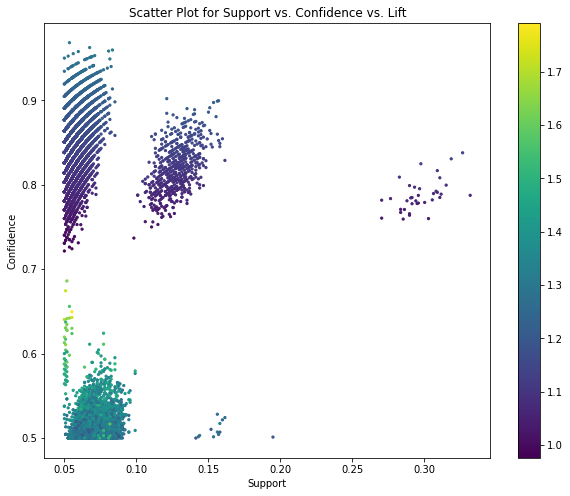

In [101]:
plt.subplots(figsize=(10, 8))
plt.scatter(rules.support, rules.confidence, c=rules.lift, s=5)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Scatter Plot for Support vs. Confidence vs. Lift')
plt.colorbar()
plt.show()

We can filter the rules the following way:

In [102]:
rules.query('support > 0.05 and confidence > 0.9 and lift > 1.3')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6601,"(sandwich loaves, eggs, dishwashing liquid/det...",(vegetables),0.055312,0.739245,0.053556,0.968254,1.309788,0.012667,8.213784
7433,"(sandwich loaves, eggs, poultry)",(vegetables),0.070237,0.739245,0.067603,0.962500,1.302004,0.015681,6.953468


> Now filter for the rules in the top right corner (support greater than 0.2 and confidence greater than 0.7). What do these rules have in common? Answer the question on ILIAS

In [105]:
rules.query('support > 0.2 and confidence > 0.7 and lift ')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(aluminum foil),(vegetables),0.384548,0.739245,0.310799,0.808219,1.093304,0.026524,1.359651
1,(bagels),(vegetables),0.385426,0.739245,0.300263,0.779043,1.053836,0.015339,1.180118
2,(beef),(vegetables),0.374890,0.739245,0.291484,0.777518,1.051773,0.014348,1.172025
3,(butter),(vegetables),0.367867,0.739245,0.283582,0.770883,1.042798,0.011639,1.138087
4,(cereals),(vegetables),0.395961,0.739245,0.310799,0.784922,1.061789,0.018087,1.212377
5,(cheeses),(vegetables),0.390694,0.739245,0.309043,0.791011,1.070026,0.020225,1.247699
6,(coffee/tea),(vegetables),0.379280,0.739245,0.289728,0.763889,1.033337,0.009347,1.104374
8,(dinner rolls),(vegetables),0.388938,0.739245,0.308165,0.792325,1.071803,0.020645,1.255592
9,(dishwashing liquid/detergent),(vegetables),0.388060,0.739245,0.306409,0.789593,1.068107,0.019538,1.239287
10,(eggs),(vegetables),0.389816,0.739245,0.326602,0.837838,1.133370,0.038433,1.607989


> Let's look at the rules which have a lift greater than 1.6. Are these rules interesting?

In [106]:
rules.query('lift > 1.6 ')

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2338,"(aluminum foil, yogurt, poultry)",(juice),0.080773,0.376646,0.050044,0.619565,1.644953,0.019621,1.638530
2358,"(toilet paper, aluminum foil, yogurt)",(juice),0.078139,0.376646,0.050044,0.640449,1.700401,0.020613,1.733703
2464,"(aluminum foil, yogurt, poultry)",(mixes),0.080773,0.375768,0.050922,0.630435,1.677722,0.020570,1.689098
2694,"(cheeses, bagels, cereals)",(sandwich bags),0.083406,0.367867,0.050922,0.610526,1.659641,0.020239,1.623045
2695,"(sandwich bags, bagels, cereals)",(cheeses),0.075505,0.390694,0.050922,0.674419,1.726209,0.021423,1.871441
4325,"(cheeses, cereals, yogurt)",(coffee/tea),0.081651,0.379280,0.050044,0.612903,1.615965,0.019075,1.603526
4436,"(spaghetti sauce, cereals, poultry)",(dinner rolls),0.080773,0.388938,0.050922,0.630435,1.620915,0.019506,1.653463
6014,"(pasta, paper towels, dinner rolls)",(eggs),0.081651,0.389816,0.051800,0.634409,1.627458,0.019971,1.669034
6015,"(dinner rolls, eggs, paper towels)",(pasta),0.086040,0.371378,0.051800,0.602041,1.621098,0.019846,1.579613
6032,"(soda, dinner rolls, poultry)",(eggs),0.082529,0.389816,0.051800,0.627660,1.610145,0.019629,1.638781


That's it for the topic of Association Rules!